# Mixture of betas
Use `edward` to implement a mixture of beta distributions. Fit to Lorenz's $p$-values.

Import packages.

In [189]:
import numpy as np
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt

Configuration

In [190]:
np.random.seed(37)
plt.rcParams['figure.figsize'] = (12, 8)

## Load data
The first two columns are $p$-values from different methods, the last is the posterior probability.

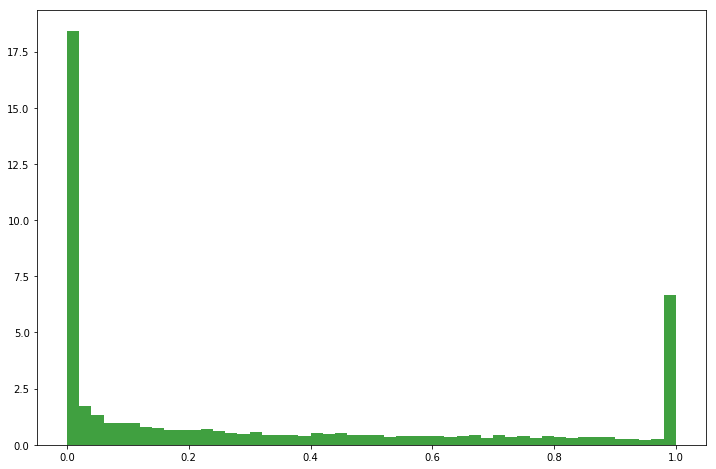

array([  5.26770000e-04,   1.00000000e+00,   3.31000000e-14, ...,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [191]:
pvals = np.loadtxt('john_pvals.csv', skiprows=1, delimiter=',')
cshl_pvals = pvals[:,0]  # p-values from CSHL method
sav_pvals = pvals[:,1]   # p-values from SAV method
posterior_probs = pvals[:,2]
plt.hist(cshl_pvals, 50, normed=1, facecolor='green', alpha=0.75)
plt.show()
cshl_pvals

Only use a subset of the CSHL p-values that are not too extreme as we tend to get `NaN`s when we have $p$-values very close to 0 or 1.

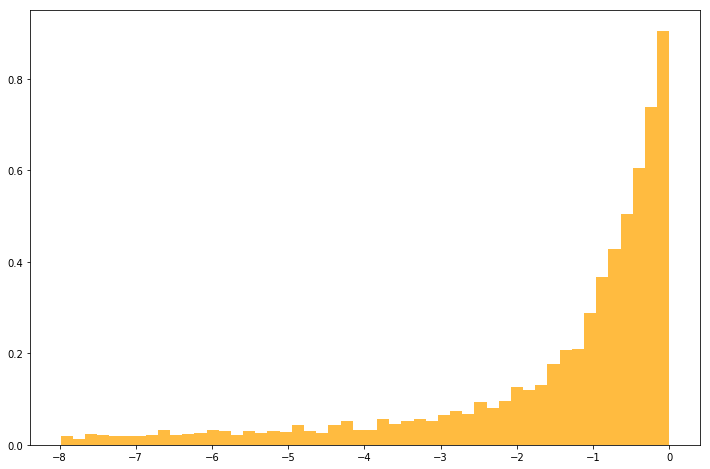

In [192]:
idxs = (cshl_pvals > 1e-8) & (cshl_pvals < 1)
x_nonextreme = cshl_pvals[idxs]
x_nonextreme
plt.hist(np.log10(x_nonextreme), 50, normed=1, facecolor='orange', alpha=0.75)
plt.show()
N = 5000
subset = np.random.choice(len(x_nonextreme), N, replace=False)
x_train = x_nonextreme[subset]

## Model
Our model is a mixture of $K$ betas.

\begin{equation}
p(x_n|\pi, \alpha, \beta) = \sum_{k=1}^K \pi_k \text{Beta}(\alpha_k, \beta_k)
\end{equation}

In [193]:
from edward.models import Categorical, Mixture, Beta, InverseGamma, Dirichlet
K = 3  # number of components
a = InverseGamma(alpha=tf.ones([K]), beta=tf.ones([K]))
b = InverseGamma(alpha=tf.ones([K]), beta=tf.ones([K]))
pi = Dirichlet(tf.ones([K]))
cat = Categorical(p=tf.ones([N,K]) * pi)
components = [
    Beta(a=tf.ones([N]) * a[k],
         b=tf.ones([N]) * b[k])
    for k in range(K)]
x = Mixture(cat=cat, components=components)

## Variational distribution
We use inverse gamma variational distributions over each $\alpha$ and $\beta$.

In [194]:
qa = InverseGamma(
    alpha=tf.nn.softplus(tf.Variable(tf.random_normal([K]))),
    beta =tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
qb = InverseGamma(
    alpha=tf.nn.softplus(tf.Variable(tf.random_normal([K]))),
    beta =tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

We use a Dirichlet variational distribution for $\pi$.

In [195]:
qpi = Dirichlet(tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

## Inference

In [212]:
inference = ed.KLqp({a: qa, b: qb, pi: qpi}, data={x: x_train})
inference.run(n_iter=1500, n_samples=200)

Iteration    1 [  0%]: Loss = 5329.009
Iteration  150 [ 10%]: Loss = -5365.344
Iteration  300 [ 20%]: Loss = -5459.159
Iteration  450 [ 30%]: Loss = -5559.645
Iteration  600 [ 40%]: Loss = -5618.321
Iteration  750 [ 50%]: Loss = -5701.119
Iteration  900 [ 60%]: Loss = -5671.741
Iteration 1050 [ 70%]: Loss = -5686.500
Iteration 1200 [ 80%]: Loss = -5721.899
Iteration 1350 [ 90%]: Loss = -5768.510
Iteration 1500 [100%]: Loss = -5716.614


## Posterior

Evaluate the posterior mean of $\pi$.

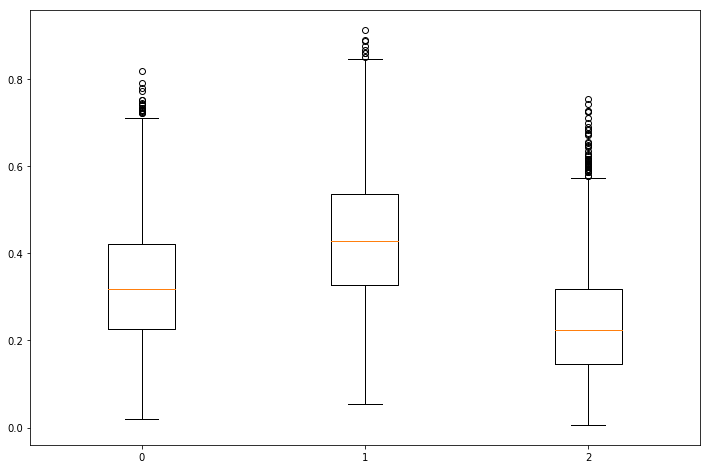

In [198]:
plt.boxplot(qpi.sample(5000).eval(), labels = range(K))
plt.show()

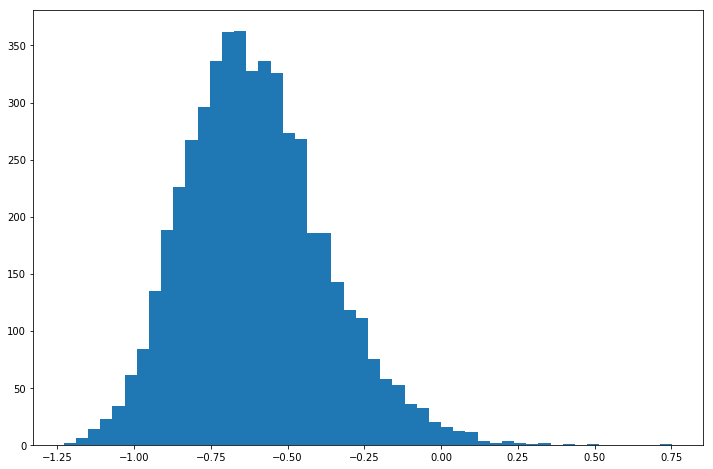

In [199]:
plt.hist(np.log10(qa.sample(5000).eval()[:,0]), bins=50)
plt.show()

Plot $a$ against $b$.

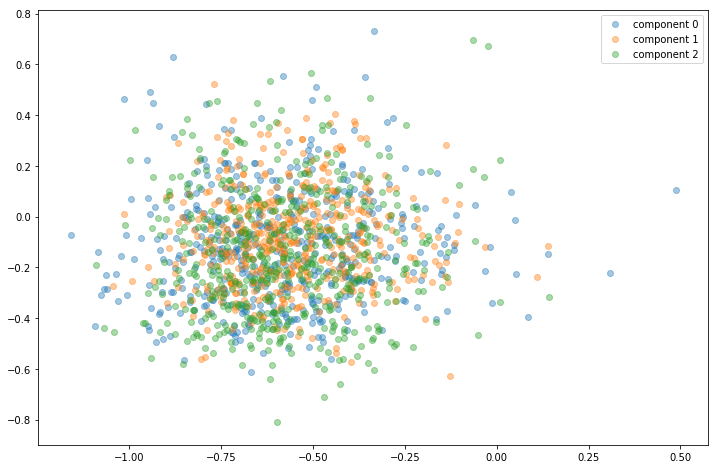

In [200]:
a_sample = qa.sample(500).eval()
b_sample = qb.sample(500).eval()
sc = [
    plt.scatter(np.log10(a_sample[:,k]),
                np.log10(b_sample[:,k]),
                label = 'component {}'.format(k),
                alpha = .4)
    for k in range(K)]
plt.legend()
plt.show()

Plot the means of each component.

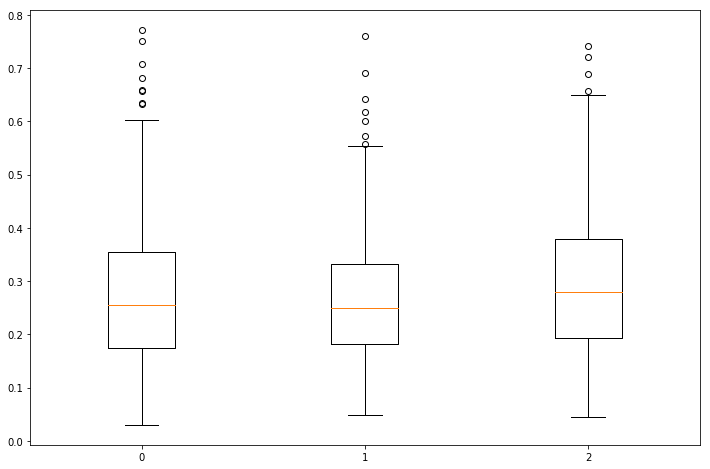

In [201]:
compmean = a_sample / (a_sample + b_sample)
plt.boxplot(compmean, labels = range(K))
plt.show()

Plot the component beta distributions using samples of $a$ and $b$.

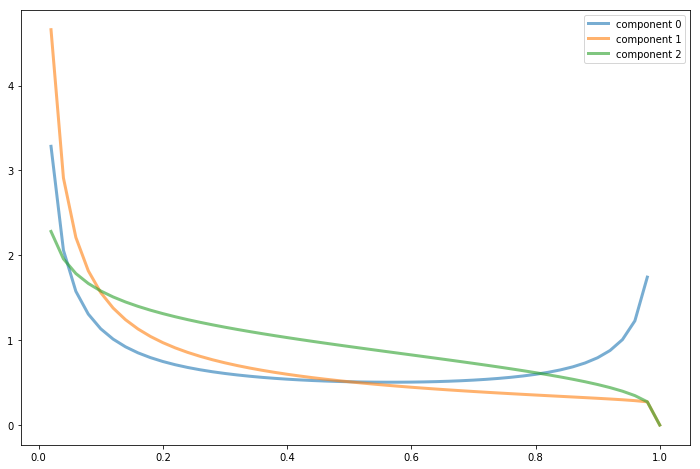

In [202]:
from scipy.stats import beta
p = np.linspace(0, 1, 51)
def plot_comp_pdfs(s):
    for k in range(K):
        comppdf = beta.pdf(p, a_sample[s,k], b_sample[s,k])
        plt.plot(p, comppdf, lw=3, alpha=0.6, label='component {}'.format(k))
    plt.legend()
plot_comp_pdfs(np.random.choice(a_sample.shape[0]))
plt.show()

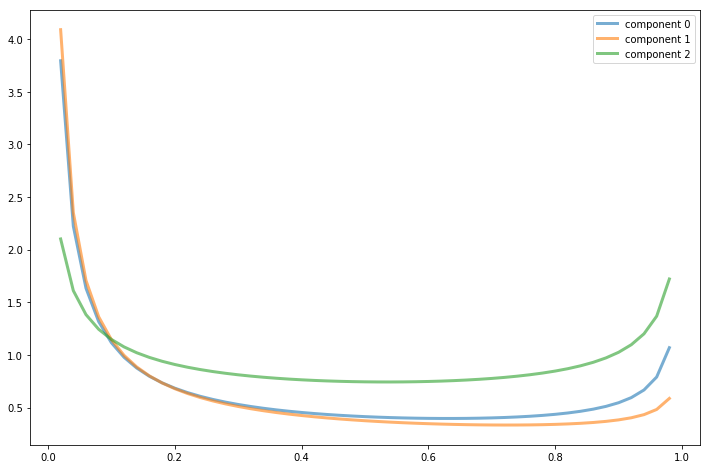

In [203]:
plot_comp_pdfs(np.random.choice(a_sample.shape[0]))
plt.show()

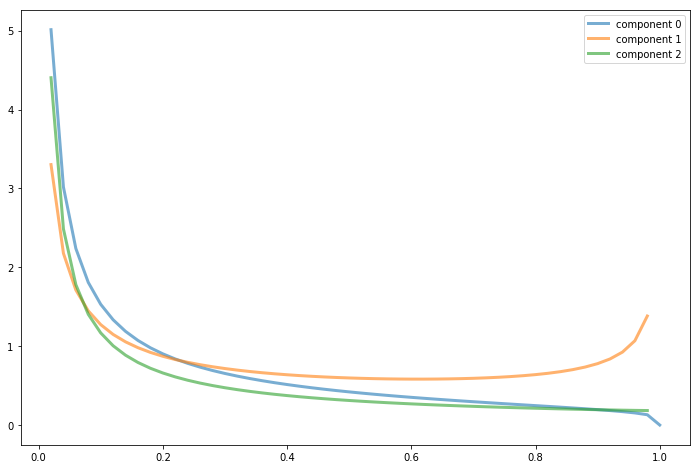

In [204]:
plot_comp_pdfs(np.random.choice(a_sample.shape[0]))
plt.show()

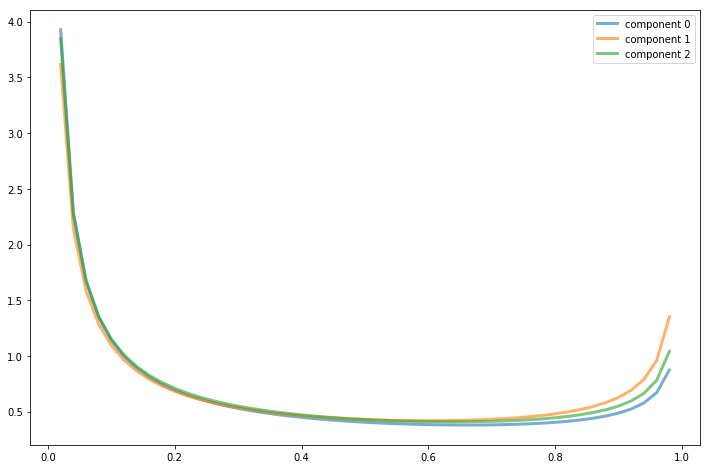

In [205]:
plot_comp_pdfs(np.random.choice(a_sample.shape[0]))
plt.show()

## Criticism
Visualise the predicted memberships of each data point.

In [206]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
a_sample = qa.sample(100)
b_sample = qb.sample(100)
pi_sample = qpi.sample(100)
pi_log = tf.log(tf.ones([N,100,K]) * pi_sample)
x_post = Beta(a=tf.ones([N, 1, 1]) * a_sample,
              b=tf.ones([N, 1, 1]) * b_sample)
x_broadcasted = tf.tile(tf.reshape(x_train.astype('float32'), [N, 1, 1]),
                        [1, 100, K])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted) + pi_log
log_liks = tf.reduce_mean(log_liks, 1)

Take the argmax along the columns to find the cluster assignments

In [207]:
clusters = tf.argmax(log_liks, 1).eval()

Plot a histogram showing how many $p$-values are assigned to each cluster.

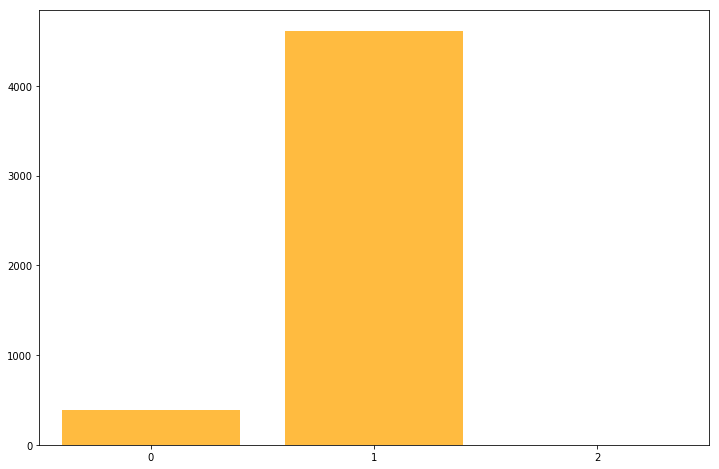

In [208]:
from matplotlib.ticker import MaxNLocator
unique, counts = np.unique(clusters, return_counts=True)
plt.bar(unique, counts, facecolor='orange', alpha=0.75)
plt.xlim(-.5, K-.5)
plt.axes().get_xaxis().set_major_locator(MaxNLocator(integer=True))
plt.show()